# EEG Wheelchair Binary Classification ML Model
## Using 1D Convolutional Networks and Recurrent Networks
This is the first experiment with trying to convert 4 channel EEG brain wave data into a binary classification of stop and go for the EEG wheelchair control system.

## Overview
The following notebook will follow these next steps:
1. Data Cleaning
    - Get rid of inconsistent samples or bad samples
2. Data Preprocessing
    - Convert to wavelet transforms and take signal squeezed signals
3. Data Filtering
    - Filter out irrelevant frequencies and disconnections
4. Build Model
    - Form CNN-RNN network for prediction modelling
5. Model Training
    - Train model on training set of EEG Samples
6. Hyperparameter Optimization
    - Optimize model hyperparameters by cross validation 
7. Model Validation
    - Validate model on test set


In [1]:
# Basic imports
from datetime import datetime
import numpy as np
import glob
import os
import sys
from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import random
from time import sleep

# Data management
import pandas as pd

# Data processing
from ssqueezepy import ssq_cwt

# Model training
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, SpatialDropout1D, SpatialDropout2D, BatchNormalization
from tensorflow.keras.layers import Flatten, InputSpec, Layer, Concatenate, AveragePooling2D, MaxPooling2D, Reshape, Permute
from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D, LayerNormalization
from tensorflow.keras.layers import TimeDistributed, Lambda, AveragePooling1D, Add, Conv1D, Multiply
from tensorflow.keras.constraints import max_norm, unit_norm 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import mode

## Experiment Information
Record the experiment information in these fields to be saved with the experiment

In [2]:
trial_num = 4
attempt_num = 21

output_dim = 4
attempt_description = \
"""
## 21th attempt

### Changes made
Trying movement dataset 4 with new technique

"""

In [3]:
# Make directories to save data
model_dir = './models/trial%s' % trial_num
results_dir = './results/trial%s/attempt%s' % (trial_num, attempt_num)
interm_dir = './processed_data/trial%s/attempt%s' % (trial_num, attempt_num)

model_file = os.path.join(model_dir, 'attempt%s.h5' % (attempt_num))
summary_file = os.path.join(results_dir, 'attempt%s_summary.txt' % attempt_num)
description_file = os.path.join(results_dir, 'attempt%s_readme.md' % attempt_num)
accuracy_graph = os.path.join(results_dir, 'attempt%s_accuracy.png' % attempt_num)
loss_graph = os.path.join(results_dir, 'attempt%s_loss.png' % attempt_num)
conf_matrix = os.path.join(results_dir, 'attempt%s_confusion.png' % attempt_num)
log_file = os.path.join(results_dir, 'attempt%s.log' % attempt_num)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
if not os.path.exists(interm_dir):
    os.makedirs(interm_dir)
    
# Save description
with open(description_file, 'w') as f:
    f.write(attempt_description)
    f.close()


## Importing Data

In [5]:
label_map = {0: "BRAKE",
             1: "ACCEL",
             2: "LEFT",
             3: "RIGHT",
             4: "PASSIVE",
             5: "DISCONNECTED",
             6: "AMBIGUOUS"}

SEGMENT_WINDOW_SIZE = 400 # 2s
ACTIVE_WAIT_PERIOD = 50 # 1s
ACTIVE_HOLD_PERIOD = 100 # 0.5s for dealing with accidental presses

In [ ]:
def rolling_mode_smoothing(data, window):
    output = []
    for frame in pd.Series(data).rolling(window):
        output.append(mode(frame)[0])
        
    return np.array(output)

In [ ]:
def show_hist(files):
    X = []
    t = []
    for file in files:
        session = pd.read_csv(file, header=None).to_numpy()
        segment_lengths = defaultdict(list)
        count = 0
        timestamps = session[:, 0]
        speeds = session[:, 1]
        data = session[:, 3:]
        
        segment_count = 0
        
        for i in range(len(session)-1):
            segment_count += 1
            if speeds[i] != speeds[i+1] or i+1 == len(session) - 1:
                segment_lengths[speeds[i]].append(segment_count)
                segment_count = 0
        
        plt.title('BRAKE, %s' % file)
        plt.hist(segment_lengths[0], bins=15)
        plt.show()
        plt.title('ACCEL, %s' % file)
        plt.hist(segment_lengths[1], bins=15)
        plt.show()
        plt.title('PASSIVE, %s' % file)
        plt.hist(segment_lengths[4], bins=15)
        plt.show()
        plt.title('DISCONNECTED, %s' % file)
        plt.hist(segment_lengths[5], bins=15)
        plt.show()

In [ ]:
#SMOOTHING_WINDOW = 100 # Eliminates any bumps under 0.25s
def compile_speed_segments(files):
    X = []
    t = []
    for file in files:
        session = pd.read_csv(file, header=None).to_numpy()
        
        count = 0
        timestamps = session[:, 0]
        speeds = session[:, 1]
        data = session[:, 3:]
        
        plt.plot((speeds*200))
        plt.plot(data[:, 0])

        plt.title("Accel break label")
        plt.show()
        
        # smooth out labels
#         speeds = rolling_mode_smoothing(speeds, SMOOTHING_WINDOW)
#         plt.plot(timestamps, speeds)
#         plt.show()
        
        discon_segment = []
        
        for i in range(len(session)-1):
            if timestamps[i+1] - timestamps[i] > 1000000000:
                print("OSC delay too long")
                
            # If the data was ambiguous, then skip
            if speeds[i] == 6:
                continue
                
            # If the data is disconnected, collect in disconnected segments'
            if speeds[i] == 5:
                discon_segment.append(data[i])
                
            # reaching max disconnected size save as segment
            if len(discon_segment) == SEGMENT_WINDOW_SIZE:
                X.append(discon_segment)
                t.append(np.eye(len(label_map))[int(speeds[i])])
                discon_segment = []
            
            # Clear if reached end of disconnect
            if speeds[i] == 5 and speeds[i+1] != 5:
                discon_segment = []
            
            if speeds[i] != speeds[i+1]:
                # Observe rising edge as data
                if speeds[i+1] in (1, 0):
                    if (speeds[i+1:i+ACTIVE_HOLD_PERIOD] == speeds[i+1]).all() and \
                            len(data[i-int(SEGMENT_WINDOW_SIZE/2)+1:i+int(SEGMENT_WINDOW_SIZE/2)+1]) == SEGMENT_WINDOW_SIZE:
                        # Save speed segments at the rising edge of every active region
                        X.append(data[i-int(SEGMENT_WINDOW_SIZE/2)+1:i+int(SEGMENT_WINDOW_SIZE/2)+1])
                        t.append(np.eye(len(label_map))[int(speeds[i+1])])
                if speeds[i+1] == 4:
                    # if the user is still holding the button ns after the rising edge, then it is passive data
                    if (speeds[i+1:i+1+int(ACTIVE_WAIT_PERIOD)+SEGMENT_WINDOW_SIZE] == speeds[i+1]).all() and \
                            len(data[i+1+int(ACTIVE_WAIT_PERIOD):i+1+int(ACTIVE_WAIT_PERIOD)+SEGMENT_WINDOW_SIZE]) == SEGMENT_WINDOW_SIZE:
                        X.append(data[i+1+int(ACTIVE_WAIT_PERIOD):i+1+int(ACTIVE_WAIT_PERIOD)+SEGMENT_WINDOW_SIZE])
                        t.append(np.eye(len(label_map))[4])

    return np.array(X).astype(np.float32), np.array(t).astype(np.float32)

In [8]:
#SMOOTHING_WINDOW = 100 # Eliminates any bumps under 0.25s
def compile_speed_segments(files):
    X = []
    t = []
    for file in files:
        session = pd.read_csv(file, header=None).to_numpy()
        
        count = 0
        timestamps = session[:, 0]
        speeds = session[:, 1]
        data = session[:, 3:]
        
        plt.plot((speeds*200))
        plt.plot(data[:, 0])

        plt.title("Accel break label")
        plt.show()
        
        # smooth out labels
#         speeds = rolling_mode_smoothing(speeds, SMOOTHING_WINDOW)
#         plt.plot(timestamps, speeds)
#         plt.show()
        
        discon_segment = []
        
        for i in range(len(session)-1):
            if timestamps[i+1] - timestamps[i] > 1000000000:
                print("OSC delay too long")
                
            # If the data was ambiguous, then skip
            if speeds[i] == 6:
                continue
                
            # If the data is disconnected, collect in disconnected segments'
            if speeds[i] == 5:
                discon_segment.append(data[i])
                
            # reaching max disconnected size save as segment
            if len(discon_segment) == SEGMENT_WINDOW_SIZE:
                X.append(discon_segment)
                t.append(np.eye(len(label_map))[int(speeds[i])])
                discon_segment = []
            
            # Clear if reached end of disconnect
            if speeds[i] == 5 and speeds[i+1] != 5:
                discon_segment = []
            
            if speeds[i] != speeds[i+1]:
                # Observe rising edge as data
                if speeds[i+1] in (1, 0):
                    if (speeds[i+1:i+ACTIVE_HOLD_PERIOD] == speeds[i+1]).all() and \
                            len(data[i-int(SEGMENT_WINDOW_SIZE)+1:i+1]) == SEGMENT_WINDOW_SIZE:
                        # Save speed segments at the rising edge of every active region
                        X.append(data[i-int(SEGMENT_WINDOW_SIZE)+1:i+1])
                        t.append(np.eye(len(label_map))[int(speeds[i+1])])
                    # if the user is still holding the button ns after the rising edge, then it is passive data
                    if (speeds[i+1:i+1+int(ACTIVE_WAIT_PERIOD)+SEGMENT_WINDOW_SIZE] == speeds[i+1]).all() and \
                            len(data[i+1+int(ACTIVE_WAIT_PERIOD):i+1+int(ACTIVE_WAIT_PERIOD)+SEGMENT_WINDOW_SIZE]) == SEGMENT_WINDOW_SIZE:
                        X.append(data[i+1+int(ACTIVE_WAIT_PERIOD):i+1+int(ACTIVE_WAIT_PERIOD)+SEGMENT_WINDOW_SIZE])
                        t.append(np.eye(len(label_map))[4])

    return np.array(X).astype(np.float32), np.array(t).astype(np.float32)

In [ ]:

def compile_direction_segments(files):
    X = []
    t = []

    for file in files:
        session = pd.read_csv(file, header=None).to_numpy()
        
        count = 0
        timestamps = session[:, 0]
        directions = session[:, 2]
        data = session[:, 3:]
        
        plt.plot(timestamps, directions)
        plt.plot(timestamps)
        plt.title("Left right label")
        plt.show()
        #plt.plot(timestamps, rolling_mode_smoothing(directions, SMOOTHING_WINDOW))
        #plt.show()
        
        discon_segment = []
        straight_segment = []
        
        for i in range(len(session)-1):
            if timestamps[i+1] - timestamps[i] > 1000000000:
                print("OSC delay too long")
                
            # If the data was ambiguous, then skip
            if directions[i] == 6:
                continue
                
            # If the data is disconnected, collect in disconnected segments'
            if directions[i] == 5:
                discon_segment.append(data[i])
                
            # reaching max disconnected size save as segment
            if len(discon_segment) == SEGMENT_WINDOW_SIZE:
                X.append(discon_segment)
                t.append(np.eye(len(label_map))[int(directions[i])])
                discon_segment = []
            
            # Clear if reached end of disconnect
            if directions[i] == 5 and directions[i+1] != 5:
                discon_segment = []
                
            # If the direction is passive, collect as a segment
            if directions[i] == 4:
                straight_segment.append(data[i])
            
            if len(straight_segment) == SEGMENT_WINDOW_SIZE:
                X.append(straight_segment)
                t.append(np.eye(len(label_map))[int(directions[i])])
                straight_segment = []
                
            if directions[i] == 4 and directions[i+1] != 4:
                straight_segment = []
            
            if directions[i] != directions[i+1]:
                # Save turn segments at the rising edge of every active region
                if directions[i+1] in (2, 3):
                    if (directions[i+1:i+ACTIVE_HOLD_PERIOD] == directions[i+1]).all() and \
                            len(data[i-int(SEGMENT_WINDOW_SIZE/2)+1:i+int(SEGMENT_WINDOW_SIZE/2)+1]) == SEGMENT_WINDOW_SIZE:
                        X.append(data[i-int(SEGMENT_WINDOW_SIZE/2)+1:i+int(SEGMENT_WINDOW_SIZE/2)+1])
                        t.append(np.eye(len(label_map))[int(directions[i+1])])
                
                
    return np.array(X).astype(np.float32), np.array(t).astype(np.float32)

In [9]:
data_path = './datasets/movement_dataset_v4/ridvan_167953*.csv'
files = shuffle(glob.glob(data_path))
print(files)

['./datasets/movement_dataset_v4/ridvan_1679534051.csv', './datasets/movement_dataset_v4/ridvan_1679532272.csv', './datasets/movement_dataset_v4/ridvan_1679533511.csv']


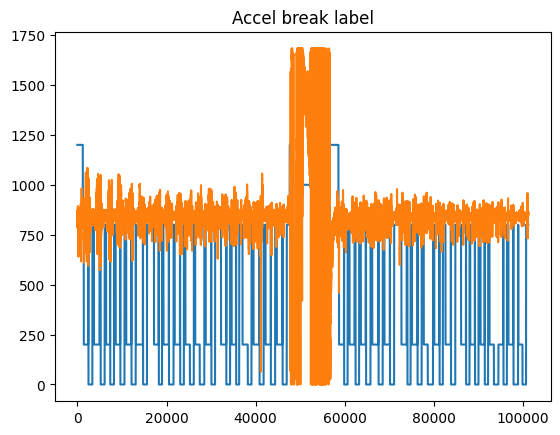

OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long


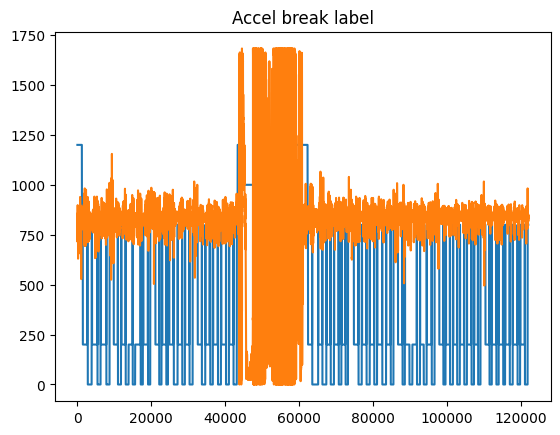

OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long


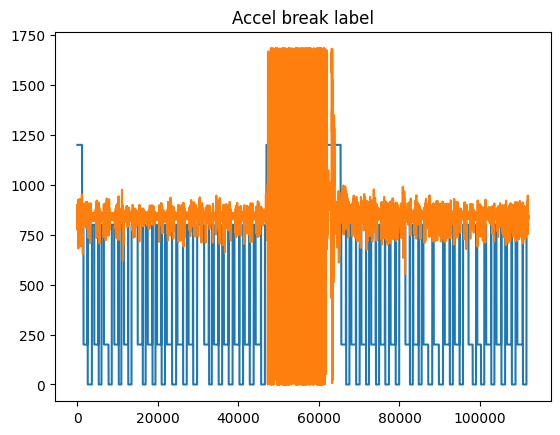

OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long


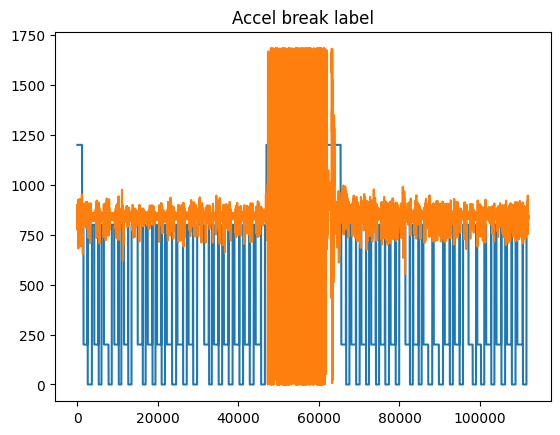

OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long
OSC delay too long


In [10]:


X_train, t_train = compile_speed_segments(files[0:2])

X_test, t_test = compile_speed_segments([files[2]])

X_val, t_val = compile_speed_segments([files[2]])

In [ ]:
show_hist(files)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

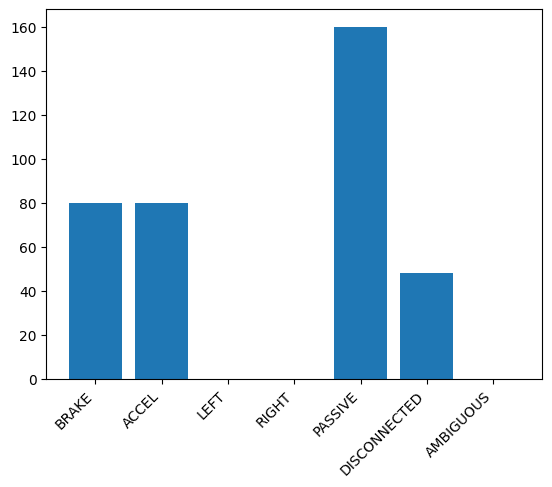

In [11]:
plt.bar(label_map.values(), t_train.sum(axis=0))
plt.xticks(rotation=45, ha="right")

In [12]:
# Shuffle the data
X_train, t_train = shuffle(X_train, t_train)
X_test, t_test = shuffle(X_test, t_test)
X_val, t_val = shuffle(X_val, t_val)

In [ ]:
counts = [0, 0, 0, 0, 0, 0]
for data in t_train:
    for i in range(len(counts)):
        if data[i] == 1:
            counts[i] += 1
  
print("Balance of categories")
print(counts)

In [ ]:
# Balance categories
def balance_categories(X, t):
    max_per_label = min(t.sum(axis=0)[np.nonzero(t.sum(axis=0))])
    counts = [max_per_label for i in range(len(t[0]))]
    new_X = []
    new_t = []

    for i in range(len(X)):
        if (np.array(new_t).sum(axis=0) + t[i] <= counts).all():
            new_X.append(X[i])
            new_t.append(t[i])
            
    return np.array(new_X), np.array(new_t)
              
X_train, t_train = balance_categories(X_train, t_train)
X_test, t_test = balance_categories(X_test, t_test)
X_val, t_val = balance_categories(X_val, t_val)

In [ ]:
plt.plot(X_train[0])
plt.show()
print(t_train[0])

plt.plot(X_train[1])
plt.show()
print(t_train[1])

plt.plot(X_train[2])
plt.show()
print(t_train[2])

plt.plot(X_train[100])
plt.show()
print(t_train[100])

In [13]:
# Reshape the data for training
X_train = X_train.transpose(0, 2, 1)

X_test = X_test.transpose(0, 2, 1)

# Reshape the data for training
X_val = X_val.transpose(0, 2, 1)

In [14]:
print("Training data")
print(X_train.shape)
print(t_train.shape)
print("Testing data")
print(X_test.shape)
print(t_test.shape)
print("Validation data")
print(X_val.shape)
print(t_val.shape)

Training data
(368, 4, 400)
(368, 7)
Testing data
(173, 4, 400)
(173, 7)
Validation data
(173, 4, 400)
(173, 7)


In [15]:
# Save the ssq data
np.save(os.path.join(interm_dir, 'x_train.npy'), X_train)
np.save(os.path.join(interm_dir, 't_train.npy'), t_train)
np.save(os.path.join(interm_dir, 'x_test.npy'), X_test)
np.save(os.path.join(interm_dir, 't_test.npy'), t_test)
np.save(os.path.join(interm_dir, 'x_val.npy'), X_val)
np.save(os.path.join(interm_dir, 't_val.npy'), t_val)


## *Shortcut: Load Preprocessed Saved Data*

In [4]:
# Load ssq data
X_train = np.load(os.path.join(interm_dir, 'x_train.npy'))
t_train = np.load(os.path.join(interm_dir, 't_train.npy'))
X_test = np.load(os.path.join(interm_dir, 'x_test.npy'))
t_test = np.load(os.path.join(interm_dir, 't_test.npy'))
X_val = np.load(os.path.join(interm_dir, 'x_val.npy'))
t_val = np.load(os.path.join(interm_dir, 't_val.npy'))

Text(0.5, 1.0, 'Time Domain EEG Data')

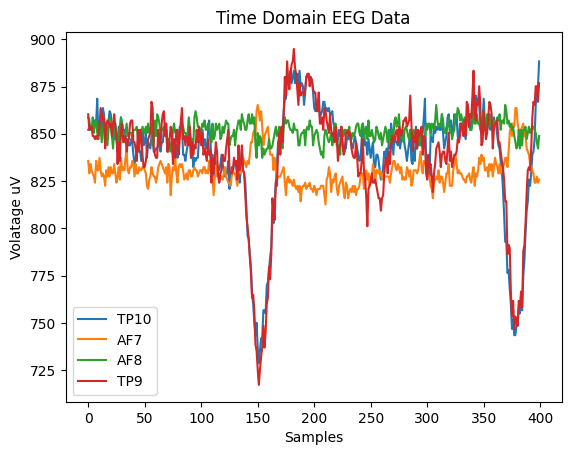

In [13]:
plt.plot(X_train[3].T)
plt.legend(['TP10', 'AF7', 'AF8', 'TP9'])
plt.xlabel("Samples")
plt.ylabel("Volatage uV")
plt.title("Time Domain EEG Data")

## Shuffle data

In [ ]:
X_train_full = X_train
X_train = X_train[:100]
t_train_full = t_train
t_train = t_train[:100]

In [ ]:
X_train.shape

In [ ]:
t_train.shape

In [ ]:
np.argwhere(np.isnan(X_train))

## Train Model

In [53]:
num_frames = len(X_train)
num_channels = len(X_train[0])
frame_size = len(X_train[0][0])

print('Training data dimensions = (%s, %s, %s)' % (num_frames, num_channels, frame_size))

n_ff = [2,4,8,16]    # Number of frequency filters for each inception module of EEG-ITNet
n_sf = [1,1,1,1]     # Number of spatial filters in each frequency sub-band of EEG-ITNet

drop_rate = 0.2

# Input layer
input_layer = Input(shape=(num_channels, frame_size, 1))

block1 = Conv2D(n_ff[0], (1, 16), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_1')(input_layer)
block1 = BatchNormalization()(block1)
block1 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[0], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_1')(block1)
block1 = BatchNormalization()(block1)
block1 = Activation('elu')(block1)

#================================

block2 = Conv2D(n_ff[1], (1, 32), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_2')(input_layer)
block2 = BatchNormalization()(block2)
block2 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[1], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_2')(block2)
block2 = BatchNormalization()(block2)
block2 = Activation('elu')(block2)

#================================

block3 = Conv2D(n_ff[2], (1, 64), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_3')(input_layer)
block3 = BatchNormalization()(block3)
block3 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[2], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_3')(block3)
block3 = BatchNormalization()(block3)
block3 = Activation('elu')(block3)

#================================

block4 = Conv2D(n_ff[3], (1, 128), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_4')(input_layer)
block4 = BatchNormalization()(block4)
block4 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[3], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_4')(block4)
block4 = BatchNormalization()(block4)
block4 = Activation('elu')(block4)

#================================

block = Concatenate(axis = -1)([block1, block2, block3, block4]) 

#================================

block = AveragePooling2D((1, 4))(block)
block_in = Dropout(drop_rate)(block)

#================================

paddings = tf.constant([[0,0], [0,0], [3,0], [0,0]])
block = tf.pad(block_in, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 1))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 1))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_in, block])


paddings = tf.constant([[0,0], [0,0], [6,0], [0,0]])
block = tf.pad(block_out, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 2))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 2))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_out, block])


paddings = tf.constant([[0,0], [0,0], [12,0], [0,0]])
block = tf.pad(block_out, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 4))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 4))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_out, block]) 


paddings = tf.constant([[0,0], [0,0], [24,0], [0,0]])
block = tf.pad(block_out, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 8))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 8))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_out, block]) 

#================================

block = block_out

#================================

block = Conv2D(28, (1,1))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = AveragePooling2D((1,4), data_format='Channels_last')(block) #'Channels_last' As CPU will be used for inference
block = Dropout(drop_rate)(block) 
embedded = Flatten()(block)

dense = Dense(128, activation='relu')(embedded)
dense = Dropout(drop_rate)(dense)
dense = Dense(64, activation='relu')(dense)
output = Dense(7, activation='softmax', kernel_constraint = max_norm(0.2))(embedded)
    
model = Model(inputs=input_layer, outputs=output)

Training data dimensions = (385, 4, 400)


In [54]:
adam = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, clipvalue=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
with open(summary_file, 'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    fh.close()
    
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4, 400, 1)]  0                                            
__________________________________________________________________________________________________
Spectral_filter_1 (Conv2D)      (None, 4, 400, 2)    32          input_2[0][0]                    
__________________________________________________________________________________________________
Spectral_filter_2 (Conv2D)      (None, 4, 400, 4)    128         input_2[0][0]                    
__________________________________________________________________________________________________
Spectral_filter_3 (Conv2D)      (None, 4, 400, 8)    512         input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.get_weights()

In [ ]:
sys.stdout = stdout
f.close()

In [55]:
stdout = sys.stdout
f = open(log_file, 'w')
sys.stdout = f
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_file,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
try:
    results = model.fit(X_train, t_train, validation_data=(X_val, t_val), batch_size=32, epochs=500, shuffle=True, callbacks=[model_checkpoint_callback])
    sys.stdout = stdout
    f.close()
except Exception as e:
    sys.stdout = stdout
    f.close()
    print(e)
except KeyboardInterrupt as e:
    sys.stdout = stdout
    f.close()
    print(e)

In [ ]:
sys.stdout = stdout
f.close()

In [ ]:
# To save the model
#model.save(model_file)

In [6]:
model = tf.keras.models.load_model(model_file)

2023-04-09 16:48:28.112012: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-04-09 16:48:28.192632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Tesla K20Xm computeCapability: 3.5
coreClock: 0.732GHz coreCount: 14 deviceMemorySize: 5.57GiB deviceMemoryBandwidth: 232.46GiB/s
2023-04-09 16:48:28.193325: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-04-09 16:48:28.197842: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-09 16:48:28.201525: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-04-09 16:48:28.202387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-

In [33]:
test_results = model.evaluate(X_test, t_test, batch_size = 1)

173/173 [==============================] - 1s 7ms/step - loss: 0.5513 - accuracy: 0.7341


In [59]:
model.predict(X_test)

array([[1.60187278e-02, 4.12861407e-01, 1.00173856e-04, ...,
        5.70245206e-01, 5.73639467e-04, 1.00549245e-04],
       [4.28935466e-03, 2.78465450e-01, 4.58339637e-05, ...,
        7.16847360e-01, 2.60262343e-04, 4.58662398e-05],
       [3.92591283e-02, 6.73854768e-01, 2.00328475e-04, ...,
        2.85715759e-01, 5.68815507e-04, 2.00704424e-04],
       ...,
       [5.47909327e-02, 2.76964545e-01, 1.83830038e-04, ...,
        6.66621268e-01, 1.07220665e-03, 1.83606273e-04],
       [1.03880381e-02, 2.32607603e-01, 9.63512066e-05, ...,
        7.56489396e-01, 2.25934738e-04, 9.64399223e-05],
       [4.81322898e-11, 2.45203875e-08, 6.94745476e-13, ...,
        1.07363314e-06, 9.99998927e-01, 6.95737359e-13]], dtype=float32)

In [ ]:
t_test

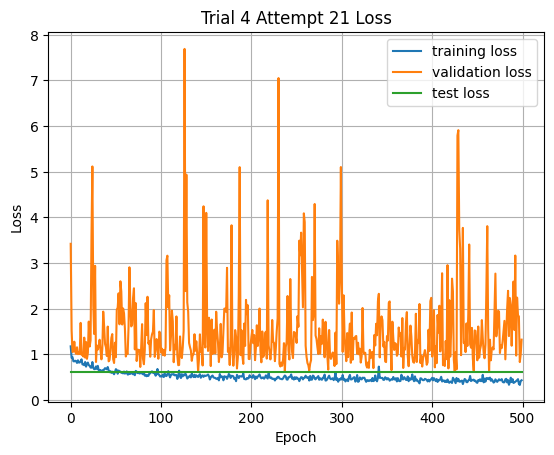

In [60]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.plot([test_results[0] for i in range(len(results.history['loss']))])
plt.legend(('training loss', 'validation loss', 'test loss'))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Trial %s Attempt %s Loss" % (trial_num, attempt_num))
plt.grid()
plt.savefig(loss_graph)

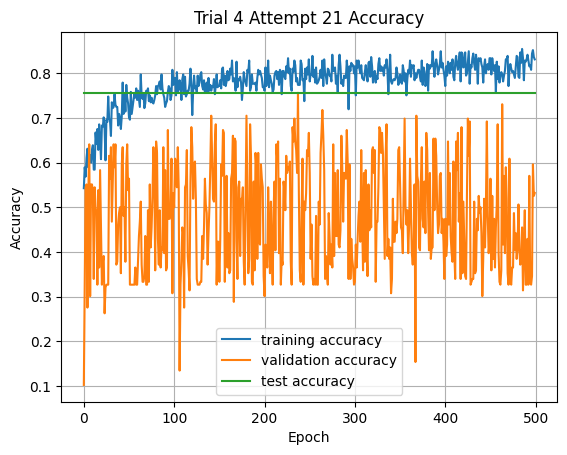

In [61]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.plot([test_results[1] for i in range(len(results.history['accuracy']))])
plt.legend(('training accuracy', 'validation accuracy', 'test accuracy'))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Trial %s Attempt %s Accuracy" % (trial_num, attempt_num))
plt.grid()
plt.savefig(accuracy_graph)

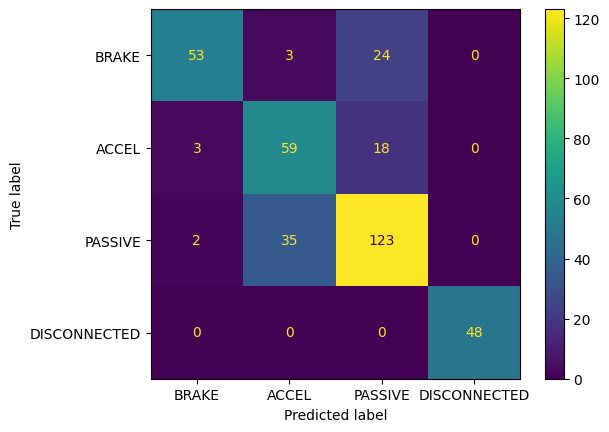

In [42]:
labels = ['BRAKE', 'ACCEL', 'PASSIVE', 'DISCONNECTED']
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(t_train, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plot = disp.plot()

disp.figure_.savefig(conf_matrix)

In [30]:
tf.keras.backend.clear_session()

# Model Visualization

(400, 4)


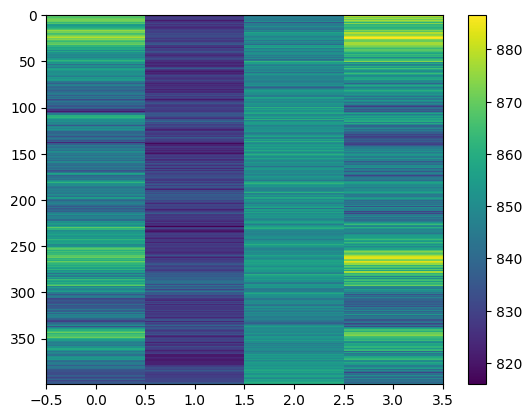

In [18]:
print(X_test[0].T.shape)
plt.imshow(X_train[1].T, interpolation='nearest', aspect='auto')
plt.colorbar()

2023-04-09 16:49:42.400379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-04-09 16:49:43.428108: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


(1, 2, 400, 4)


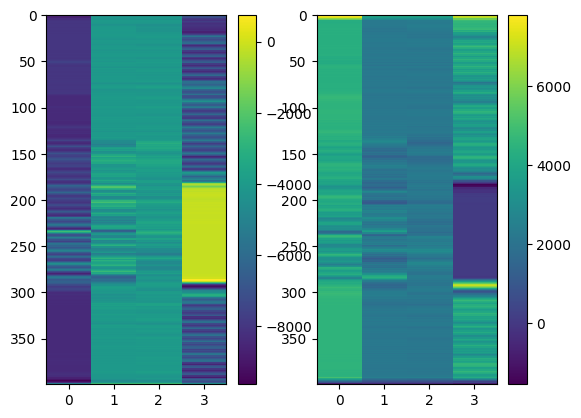

In [19]:
probe = Model(model.input, model.get_layer('Spectral_filter_1').output)
output = probe.predict(X_train[:1]).transpose(0, 3, 2, 1)
print(output.shape)
rows = 1
for num, data in enumerate(output[0]):
    plt.subplot(rows, int(len(output[0])/rows), num+1)
    plt.imshow(data, interpolation='nearest', aspect='auto')
    plt.colorbar()

(1, 2, 400, 1)


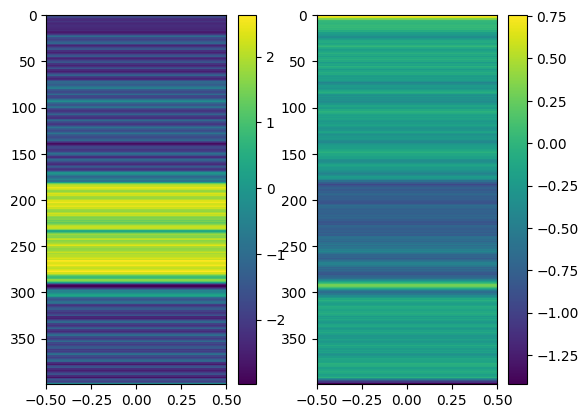

In [20]:
probe = Model(model.input, model.get_layer('Spatial_filter_1').output)
output = probe.predict(X_train[:1]).transpose(0, 3, 2, 1)
print(output.shape)
for num, data in enumerate(output[0]):
    plt.subplot(rows, int(len(output[0])/rows), num+1)
    plt.imshow(data, interpolation='nearest', aspect='auto')
    plt.colorbar()

(1, 4, 400, 4)


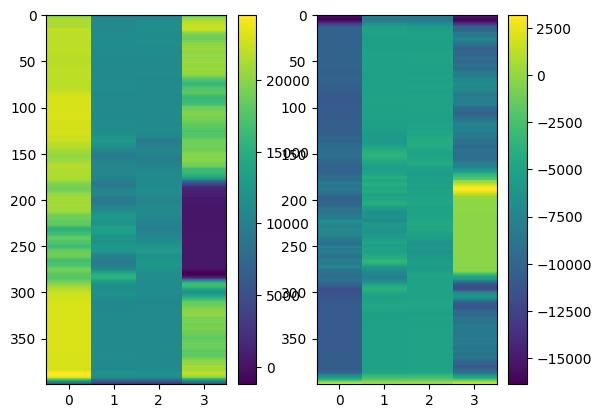

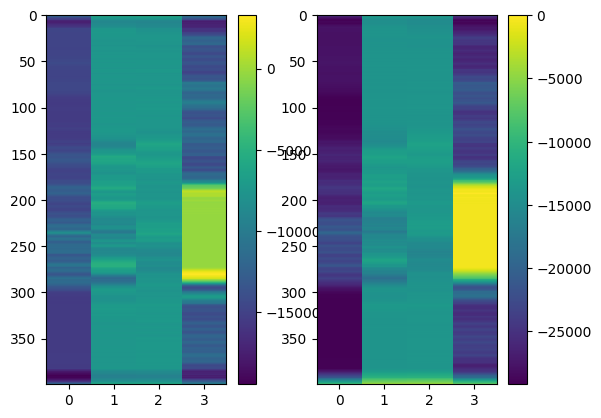

In [21]:
probe = Model(model.input, model.get_layer('Spectral_filter_2').output)
output = probe.predict(X_train[:1]).transpose(0, 3, 2, 1)
print(output.shape)
for num, data in enumerate(output[0]):
    plt.subplot(1, 2, num%2+1)
    plt.imshow(data, interpolation='nearest', aspect='auto')
    plt.colorbar()
    if num%2:
        plt.show()

(1, 1, 400, 30)


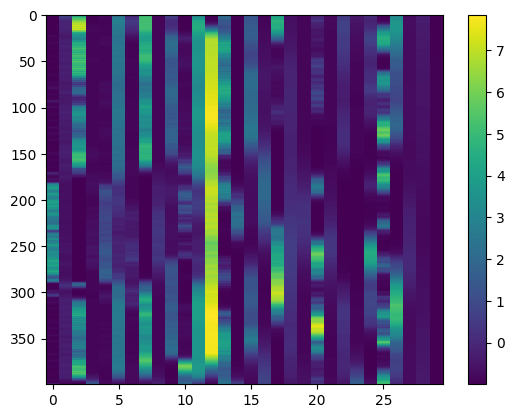

In [26]:
probe = Model(model.input, model.get_layer('concatenate_1').output)
output = probe.predict(X_train[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

(1, 1, 100, 28)


/home/ridvan/Coding/Capstone/EEG_Model_Training/venv/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


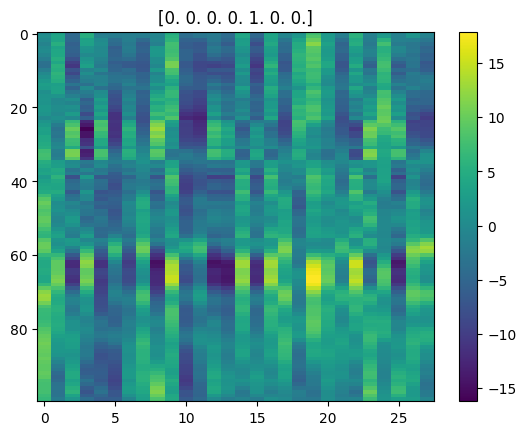

In [27]:
probe = Model(model.input, model.get_layer('conv2d_1').output)
output = probe.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.title(t_test[0])
plt.colorbar()

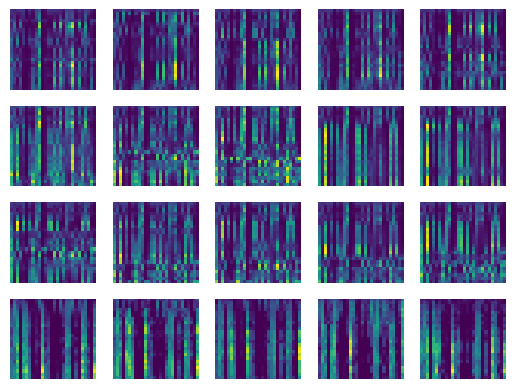

In [43]:
probe = Model(model.input, model.get_layer('dropout_20').output)

rows = 4

f, axarr = plt.subplots(4, 5)
row_counts = [0 for i in range(rows)]

for i in range(50):
    output = probe.predict(np.array([X_test[i]]))
    if t_test[i][0]:
        row = 0
    elif t_test[i][1]:
        row = 1
    elif t_test[i][4]:
        row = 2
    else:
        row = 3
    
    try:
        axarr[row, row_counts[row]].imshow(output[0][0], interpolation='nearest', aspect='auto')
        axarr[row, row_counts[row]].axis('off')
        axarr[row, row_counts[row]].axis('off')
        
    except:
        pass
    row_counts[row] += 1